# Predicting Bike Rentals

Bike sharing systems continue to pop up in a number of cities across the world as an alternative form of transportation. The popularity of these systems can be attributed to their ease of use and the important role they play in combating various issues, including climate change. It's estimated that over 500 bike sharing programs composed of over 5000 bikes are operating around the world today.

One of the appeals of these systems from a data science perspective is the way they explicitly record the duration of travel, departure and arrival position of each bike. By analysing this data we can get an idea of the level of mobility in a city at a given time. 

Hadi Fanaee-T at the University of Porto realised the value of this data for machine learning and compiled bike sharing data for Washington, D.C., along with corresponding weather and seasonal information, into a CSV file. The data is publicly available on the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

The aim of this project is to predict the total number of bikes people rented in a given hour under different environmental and seasonal conditions. To do this I'll create a few different machine learning models and evaluate their performance. Once a good model is identified, it can be used to forecast periods of increased mobility in the city. 

# Explore the Data

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Read CSV
hour = pd.read_csv("/Users/katestone/Desktop/CSV files/hour.csv")
hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [115]:
hour.shape

(17379, 17)

In [104]:
hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


The data is comprised of 17379 rows, with each row representing the number of bike rentals for a single hour of a single day. Columns include:

- instant: A unique sequential ID number for each row;
- dteday: The date of the rentals;
- season: The season in which the rentals occurred;
- yr: The year the rentals occurred;
- mnth: The month the rentals occurred;
- hr: The hour the rentals occurred;
- holiday: Whether or not the day was a holiday;
- weekday: The day of the week (as a number, 0 to 7);
- workingday: Whether or not the day was a working day;
- weathersit: The weather (as a categorical variable);
- temp: The temperature, on a 0-1 scale;
- atemp: The adjusted temperature;
- hum: The humidity, on a 0-1 scale;
- windspeed: The wind speed, on a 0-1 scale;
- casual: The number of casual riders (people who hadn't previously signed up with the bike sharing program);
- registered: The number of registered riders (people who had already signed up);
- cnt: The total number of bike rentals (casual + registered).

For this project I'll try to  predict the cnt column using all of the other columns except casual and registered.

# Distribution of Rentals

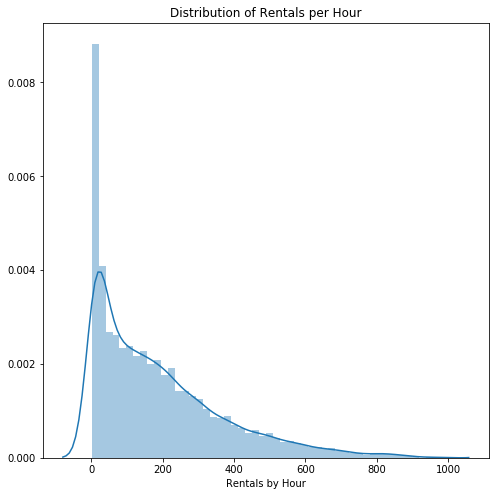

In [116]:
# Plot distribution of cnt column
plt.figure(figsize=(8,8))
sns.distplot(hour["cnt"])
plt.title("Distribution of Rentals per Hour")
plt.xlabel("Rentals by Hour")
plt.show()

The distribution of hourly rentals is skewed heavily towards the right. For most hours, rentals were between 0 and 200. 

# Check for Correlation with Rentals

In [117]:
# Get an idea of which variables have strong correlation with cnt
corrmat = hour.corr()
sorted_corrs = corrmat['cnt'].abs().sort_values(ascending=False)
sorted_corrs

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

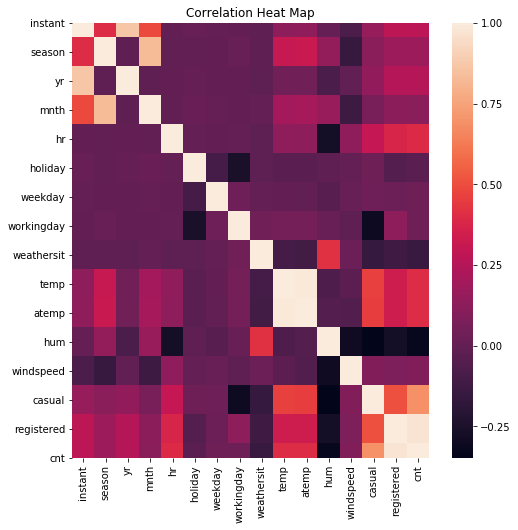

In [118]:
plt.figure(figsize=(8,8))
sns.heatmap(corrmat)
plt.title("Correlation Heat Map")
plt.show()

Temp, atemp, hr and hum have the strongest correlation with cnt (of the columns of interest). Looking at the heat map we can see that temp and atemp are highly correlated. Only one of these features will be included to avoid problems with collinearity.

# Calculate Time Label

It might be helpful to distill the unique values in the hr column into four chunks: morning, afternoon, evening and night. Grouping related hours together will likely result in the model making better decisions.

In [135]:
# Write function to group hour values into four chunks
def assign_label(x):
    if 6 <= x < 12:
        return 1
    elif 12 <= x < 18:
        return 2
    elif 18 <= x < 24:
        return 3
    else:
        return 4
    
# apply to hour column
hour["time_label"] = hour["hr"].apply(assign_label)

# Check
hour[["hr", "time_label"]].head(10)

,hr,time_label
0,0,4
1,1,4
2,2,4
3,3,4
4,4,4
5,5,4
6,6,1
7,7,1
8,8,1
9,9,1


# Linear Regression Model

Now that the data has been explored and manipulated we can begin applying linear regression. Linear regression will probably work fairly well on this data, given that many of the columns are correlated with cnt. 

Linear regression works best when predictors are linearly correlated to the target and also independent. Due to this, the casual and registered columns will be ignored as cnt is derived from them. Only one of the temperature variables will be used due to collinearity. dteday and instant will also be excluded for data leakage reasons.

To evaluate the performance of the machine learning models we'll use the mean squared error metric. MSE works on continuous numeric data, which is the case for data in the cnt column.

In [136]:
# Split the data into train and test
train = hour.sample(frac=.8)
test = hour.loc[~hour.index.isin(train.index)]

# Select predictor columns
predictors = hour.columns.drop(["instant", "atemp", "casual", "registered", "cnt", 'dteday'])

# Train lin reg model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lr = LinearRegression()
lr.fit(train[predictors], train['cnt'])

# Make predictions
predictions = lr.predict(test[predictors])
mse_lr = mean_squared_error(test["cnt"], predictions)
print("MSE for Linear Regression Model = {}".format(mse_lr))

MSE for Linear Regression Model = 16448.02353942939


The error value for the linear regression model is fairly high. This is likely due to the presence of large outliers in the rental counts. Larger errors are penalised more with MSE, which leads to a higher total error.

# Decision Tree Model

We'll now make predictions using the decision tree model. The benefit of this model over the linear regression model is that it can pick up non-linear interactions between variables that linear regression cannot. The drawback is its propensity to overfit on account of its complexity. 

In [137]:
# Train decision tree model
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree.fit(train[predictors], train['cnt'])

# Make predictions
predictions_2 = tree.predict(test[predictors])
mse_tr = mean_squared_error(test["cnt"], predictions_2)
print("MSE for Decision Tree Model = {}".format(mse_tr))

MSE for Decision Tree Model = 3325.3956415420025


Using the decision tree model over the linear regression model vastly reduces the error. However we need to check whether or not the model is overfitting. To do this we'll make predictions on the training data and compare with the predictions made on the test data. If the error for training predictions if much lower, this is a sign of overfitting. 

In [138]:
# Make predictions on training data
predictions_3 = tree.predict(train[predictors])
mse_tr_2 = mean_squared_error(train["cnt"], predictions_3)
print("Train MSE for Decision Tree Model = {}".format(mse_tr_2))

Train MSE for Decision Tree Model = 0.26893476228152197


As suspected, the decision tree model is overfitting the data. To combat this lets adjust some of the parameters to reduce the compexity of the model. 

In [139]:
# Train decision tree model
tree_2 = DecisionTreeRegressor(min_samples_leaf=10)
tree_2.fit(train[predictors], train['cnt'])

# Make predictions
predictions_4 = tree_2.predict(test[predictors])
mse_tr_2 = mean_squared_error(test["cnt"], predictions_4)
print("MSE for Decision Tree Model 2 = {}".format(mse_tr_2))

# Make predictions on training data
predictions_5 = tree_2.predict(train[predictors])
mse_train_2 = mean_squared_error(train["cnt"], predictions_5)
print("Train MSE for Decision Tree Model 2 = {}".format(mse_train_2))

MSE for Decision Tree Model 2 = 2751.39618971311
Train MSE for Decision Tree Model 2 = 1913.0120595988494


Just adding the min_samples_leaf parameter greatly reduced the level of overfitting and improved the accuracy of the predictions on the test data. 

# Random Forest Model

To improve the predictions even further we'll implement the random forest algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. 

In [140]:
# Train decision tree model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(min_samples_leaf=10, n_estimators=20)
forest.fit(train[predictors], train['cnt'])

# Make predictions
predictions_6 = forest.predict(test[predictors])
mse_forest = mean_squared_error(test["cnt"], predictions_6)
print("MSE for Random Forest Model = {}".format(mse_forest))

# Make predictions on training data
predictions_7 = forest.predict(train[predictors])
mse_train_forest = mean_squared_error(train["cnt"], predictions_7)
print("Train MSE for Random Forest Model = {}".format(mse_train_forest))

MSE for Random Forest Model = 2324.4388146125616
Train MSE for Random Forest Model = 1890.381855781096


Employing the random forest model reduced both the error and the level of overfitting even further. Now we have a model that can predict cnt with a resonable level of confidence.

# Next Steps

To increase the accuracy further we could implement the following steps:
- Calculate additional features, such as:
    - An index combining temperature, humidity, and wind speed;
- Experiment with different parameter values. 